MCS - BeNeFri
<br/>Social Media Analytics, Spring 2020
<br/>Project - Community Detection in a Facebook network
<br/>@authors: Guillaume Chacun, Fabien Vorpe

# Community Detection in a Facebook network

## Dataset

In [1]:
import networkx as nx
from tqdm import tqdm

In [96]:
edges_filename = 'example.txt' #facebook_combined

In [117]:
# Load the Facebook dataset
graph = nx.read_edgelist(f'data/{edges_filename}')
graph = nx.gnp_random_graph(100, 0.2)

edge_list = ['%i %i {\'weight\': %i}' % (int(d[0]), int(d[1]), int(d[2])) for d in list(graph.edges.data('weight', default=1))]
graph = nx.parse_edgelist(edge_list)

In [98]:
# Explore the properties of the graph

In [99]:
# print number of nodes / edges
print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())

Number of nodes: 16
Number of edges: 28


In [100]:
import matplotlib.pyplot as plt
def draw_graph(graph):
    print(graph.edges.data())
    # visualize network
    options = {
        'node_color': (0,0,1,.6),
        'node_size': 30,
        'line_color': (.8,.8,.8,1),
        'linewidths': 0,
        'width': .1,
        'with_labels': 'True',
    }
    nx.draw_networkx(graph, **options)
    plt.show()

## Algorithms implementation

### Louvain

Implement the Louvain method for community detection.  

In [101]:
def louvain_passage(graph):
    """
    Performs one passage of Louvain's algorithm to detect communities in a graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and communities' id as values
    """
    m = sum([edge[2]['weight'] for edge in graph.edges().data()])
    prev_communities = {}
    communities = {i: i for i in graph.nodes} # keys: nodes' id, values: nodes' community id
    while list(prev_communities.values()) != list(communities.values()): # while communities are changing
        prev_communities = communities.copy()
        
        communities = {k: v 
                       for k, v in sorted(communities.items(), 
                                          key=lambda item: int(item[1]))} # sort by node id (keys)
        for nodei in tqdm(communities.keys()):
            communityi = communities[nodei]
            di = sum([graph.get_edge_data(nodei, neighbor)['weight']
                      for neighbor in graph.neighbors(nodei)])
            neighbor_communities = set(communities[neighbor] for neighbor in graph.neighbors(nodei))
            
            # compute modularity gain for each neighbor community of nodei
            modularity_gains = {} # keys: community' id, values: modularity gain
            for communityj in neighbor_communities:
                nodes_in_communityj = [node for node, community in communities.items() 
                                       if community == communityj]
                dj = sum([graph.get_edge_data(node, neighbor)['weight'] 
                          for node in nodes_in_communityj
                          for neighbor in graph.neighbors(node) 
                          if node != nodei])
                # count number of neighbors of nodei that are in communityj
                links_ij = [graph.get_edge_data(nodei, node)['weight'] if node in graph.neighbors(nodei) else 0 
                            for node in nodes_in_communityj]
                dij = 2 * sum(links_ij)
                # compute modularity
                modularity_gains[communityj] = 1 / (2 * m) * (dij - (di * dj / m))
                
            # update node's community
            modularity_gains = {k: v 
                                for k, v in sorted(modularity_gains.items(), 
                                                   key=lambda item: item[1])} # sort by modularity gain (values)
            communities[nodei] = list(modularity_gains.keys())[-1]
    return communities

In [102]:
def louvain_create_hypernodes(graph, communities):
    """
    Creates the hypernodes graph after one passage of Louvain's aglorithm.
    :param graph: networkx graph
    :param communities: dictionary with graph's nodes as keys and communityies' id as values
    :returns: new networkx graph (communities became hypernodes)
    """
    new_graph = nx.Graph()
    # create hypernodes and reflective edges
    for community in set(communities.values()):
        new_graph.add_node(community)

        # count number of edges in community
        nodes_in_community = [n for n, c in communities.items() if community == c]
        links_intra_community = [1 if neighbor in nodes_in_community else 0 
                                 for node in nodes_in_community
                                 for neighbor in graph.neighbors(node)]
        new_graph.add_edge(community, community, weight=sum(links_intra_community)/2)

    # create inter communities edges
    for community in new_graph.nodes:
        nodes_in_community = [n for n, c in communities.items() if community == c]
        neighbors_of_community = [neighbor
                                  for node in nodes_in_community
                                  for neighbor in graph.neighbors(node) 
                                  if communities[neighbor] != community]
        for other_community in set(communities.values()):
            if other_community != community:
                nodes_in_other_community = [n for n, c in communities.items() if other_community == c]
                nodes_neighbors_in_other_community = [node for node in neighbors_of_community 
                                                      if node in nodes_in_other_community]
                edge_weight = len(nodes_neighbors_in_other_community)
                if other_community not in new_graph.neighbors(community) and edge_weight > 0:
                    new_graph.add_edge(community, other_community, weight=edge_weight)
    return new_graph

In [103]:
def louvain(graph):
    """
    Louvain's algorithm to detect communities in a given graph.
    :param graph: networkx graph
    :returns: graph of communities and a dictionary with graph's nodes as keys and communities' id as values
    """
    all_communities = []
    communities_id = set(graph.nodes())
    passage_id = 0
    while True: # passage
        communities = louvain_passage(graph)
        all_communities.append(communities)

        # check if modif
        if communities_id == set(communities.values()):
            break
        communities_id = set(communities.values())
        
        graph = louvain_create_hypernodes(graph, communities)
        
        passage_id += 1
        print('Graph after passage', passage_id)
        draw_graph(graph)
    return graph, all_communities

### Clustering coefficient
Implement the clustering coefficient for a graph.

In [104]:
def clustering_coefficient(graph):
    """
    Computes the clustering coefficient for each node in a given graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and their clustering coefficient as values
    """
    coeffs = {}
    for v in graph.nodes(): # compute coeff for each node
        neighbors = list(graph.neighbors(v))
        
        connected_pairs_neighbors = []
        for n1 in neighbors: # for each neighbor n1 of node v
            for n2 in graph.neighbors(n1): # for each neighbor n2 of neighbor n1 of node v
                if n2 in neighbors: # if n2 is also a neighbor of node v: (n1,n2) is a connected pair of v's neighbors
                    connected_pairs_neighbors.append((n1, n2))
        # C(v) = #connected pairs of v's neighbors / #pairs of v's neighbors
        nb_pairs_neighnbors = (len(neighbors) * (len(neighbors)-1))
        coeffs[v] = len(connected_pairs_neighbors) / nb_pairs_neighnbors if nb_pairs_neighnbors > 0 else 0
    return coeffs

### Random walk

In [105]:
def random_walk(graph, starting_node, steps, random_walk_strategy):
    """
    Visits a graph with a given random walk strategy.
    :param graph: networkx graph
    :param starting_node: node of the given graph which serves as the starting point of the random walk
    :param steps: number of steps to perform
    :param random_walk_strategy: function receiving a graph and a node and returning a node's neighbor to visit
    :returns: list of nodes in their order of visit
    """
    path = [starting_node]
    node = path[0]
    for _ in range(steps):
        node = random_walk_strategy(graph, node)
        path.append(node)
    return path

In [106]:
from random import randrange, choices

In [107]:
def rw_strategy_degree(graph, node):
    """
    Random walk strategy - the degree of a neighbor influences the probability to move to this neighbor.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    probs = [graph.degree(neighbor) for neighbor in neighbors]
    probs = [p/sum(probs) for p in probs]
    return choices(list(neighbors), probs)[0]

In [108]:
def rw_strategy_random(graph, node):
    """
    Random walk strategy - completely random.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    rdm_idx = randrange(len(neighbors)-1)
    return neighbors[rdm_idx]

## Analysis

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1066.58it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 1
[('55', '55', {'weight': 6.0}), ('55', '70', {'weight': 3}), ('55', '15', {'weight': 9}), ('55', '56', {'weight': 11}), ('55', '52', {'weight': 9}), ('55', '49', {'weight': 8}), ('55', '57', {'weight': 10}), ('55', '90', {'weight': 2}), ('55', '79', {'weight': 13}), ('70', '70', {'weight': 11.0}), ('70', '15', {'weight': 25}), ('70', '56', {'weight': 18}), ('70', '52', {'weight': 8}), ('70', '49', {'weight': 10}), ('70', '57', {'weight': 15}), ('70', '90', {'weight': 7}), ('70', '79', {'weight': 27}), ('15', '15', {'weight': 81.0}), ('15', '56', {'weight': 34}), ('15', '52', {'weight': 37}), ('15', '49', {'weight': 36}), ('15', '57', {'weight': 53}), ('15', '90', {'weight': 26}), ('15', '79', {'weight': 50}), ('56', '56', {'weight': 32.0}), ('56', '52', {'weight': 19}), ('56', '49', {'weight': 15}), ('56', '57', {'weight': 29}), ('56', '90', {'weight': 17}), ('56', '79', {'weight': 41}), ('52', '52', {'weight': 21.0}), ('52', '49', {'weight': 9}), ('52', '57', {'w

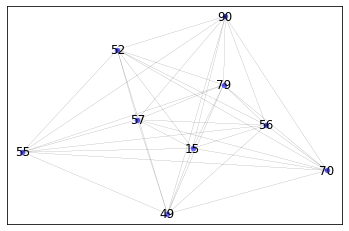

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8813.62it/s]


In [118]:
# Identify users’ communities in the Facebook network using Louvain
new_graph, communities = louvain(graph)

In [119]:
print(f'There are {len(set(communities[-1].values()))} communities.')
#print(communities)

There are 9 communities.


In [120]:
import community
louvain_communities = community.best_partition(graph)
nb_louvain_communities = len(set(louvain_communities.values()))
louvain_communities = {k: v for k, v in sorted(louvain_communities.items(), key=lambda item: item[0])} # sort by key (node id)
print(f'There are {nb_louvain_communities} communities according to Louvain\' method.')

#dendo = community.generate_dendrogram(graph)
#for level in range(len(dendo)) :
#    print("partition at level", level, "is", community.partition_at_level(dendo, level))

There are 5 communities according to Louvain' method.


In [121]:
# Identify the top k users with the highest clustering coefficient in the graph.
# Experiment with different values of k and choose the most appropriate one.
clustering_coefficients = {k: v 
                           for k, v in sorted(clustering_coefficient(graph).items(), 
                                              key=lambda item: item[1], 
                                              reverse=True)}
print(clustering_coefficients)

{'7': 0.28421052631578947, '31': 0.2619047619047619, '23': 0.25925925925925924, '35': 0.25666666666666665, '19': 0.25146198830409355, '66': 0.24561403508771928, '58': 0.24285714285714285, '76': 0.2427536231884058, '57': 0.24166666666666667, '18': 0.24110671936758893, '42': 0.23809523809523808, '72': 0.23809523809523808, '0': 0.23636363636363636, '91': 0.23529411764705882, '84': 0.23529411764705882, '98': 0.23376623376623376, '4': 0.23333333333333334, '97': 0.233201581027668, '10': 0.22924901185770752, '26': 0.22924901185770752, '61': 0.22807017543859648, '6': 0.22792022792022792, '60': 0.22792022792022792, '24': 0.22631578947368422, '33': 0.22631578947368422, '3': 0.22529644268774704, '77': 0.225, '12': 0.2222222222222222, '62': 0.2222222222222222, '92': 0.2222222222222222, '45': 0.2222222222222222, '41': 0.2222222222222222, '82': 0.22134387351778656, '73': 0.22134387351778656, '71': 0.2210144927536232, '20': 0.2210144927536232, '80': 0.22077922077922077, '67': 0.2206896551724138, '78'

In [122]:
nx.clustering(graph)

{'0': 0.23636363636363636,
 '10': 0.22924901185770752,
 '28': 0.17894736842105263,
 '38': 0.20634920634920634,
 '39': 0.19480519480519481,
 '50': 0.19607843137254902,
 '54': 0.21052631578947367,
 '69': 0.20553359683794467,
 '75': 0.19943019943019943,
 '79': 0.20346320346320346,
 '88': 0.20261437908496732,
 '96': 0.21014492753623187,
 '1': 0.18614718614718614,
 '2': 0.17647058823529413,
 '12': 0.2222222222222222,
 '14': 0.19473684210526315,
 '22': 0.21014492753623187,
 '25': 0.21052631578947367,
 '26': 0.22924901185770752,
 '34': 0.18614718614718614,
 '48': 0.1984126984126984,
 '55': 0.15833333333333333,
 '59': 0.16339869281045752,
 '62': 0.2222222222222222,
 '67': 0.2206896551724138,
 '71': 0.2210144927536232,
 '78': 0.22,
 '80': 0.22077922077922077,
 '82': 0.22134387351778656,
 '89': 0.19047619047619047,
 '92': 0.2222222222222222,
 '99': 0.17894736842105263,
 '13': 0.17316017316017315,
 '20': 0.2210144927536232,
 '30': 0.21428571428571427,
 '42': 0.23809523809523808,
 '45': 0.22222222

In [123]:
# Evaluate different random walk strategies to spread a message across the network.
# The message should reach as many different communities as possible.
starting_node = list(graph.nodes())[0]
steps = 10
rw_result_strategy_degree = random_walk(graph, starting_node, steps, rw_strategy_degree)
rw_result_strategy_random = random_walk(graph, starting_node, steps, rw_strategy_random)

print(rw_result_strategy_degree)
print(rw_result_strategy_random)

['0', '88', '85', '35', '52', '87', '7', '75', '11', '3', '36']
['0', '79', '73', '78', '22', '38', '9', '53', '67', '93', '23']


## Visualization

In [137]:
def draw_communities(graph, communities):
    #for i in set(communities[0].values()):
    #    nodes_in_i = [node for node, community in communities[0].items() if community == i]
    #    nx.draw_networkx_nodes(graph,
    #                           pos=nx.spring_layout(graph),
    #                           nodelist=nodes_in_i,
    #                           label=nodes_in_i,
    #                           node_color='r',
    #                           node_size=100,
    #                           alpha=0.8)
    #nx.draw_networkx_labels(graph,pos=nx.spring_layout(graph), labels=graph.nodes)
    nodes_community = [int(community) for community in communities[0].values()]
    nx.draw(graph, cmap=plt.get_cmap('hsv'), node_color=nodes_community, with_labels=True, font_color='white')
    plt.show()

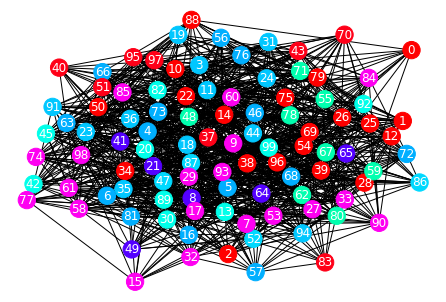

In [138]:
# Visualize the output of Louvain by coloring the nodes according to their assigned Communities.
draw_communities(graph, communities)

In [128]:
# Visualize the output of applying Random Walk algorithm, by highlighting the sequence of nodes selected in a path.